# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import tqdm
import scib_metrics

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import create_random_mask
from tardis._utils.warnings import suppress_stdout
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
def read_adata():
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    return adata

In [10]:
prefix = "afriat_v2_4_scan_"
models = {float(i.split(prefix)[1]): os.path.join(tardis.config.io_directories["models"], i) for i in os.listdir(tardis.config.io_directories["models"]) if i.startswith(prefix)}

In [11]:
models

{0.13: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.13',
 0.12: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.12',
 0.15: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.15',
 0.1225: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.1225',
 0.1383: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.1383',
 0.14: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.14',
 0.1425: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.1425',
 0.135: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.135',
 0.2: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.2',
 0.1275: '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_scan_0.1275',
 0.145: '/lustre/groups/ml01/workspace/kemal

In [44]:
def calculate_centroids_iqr(data, labels, multiplier=1.5):
    """
    Calculate centroids excluding outliers based on IQR.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
        multiplier (float): Multiplier for the IQR to define the confidence interval.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition.
    """
    unique_conditions = np.unique(labels)
    mean_centroids = dict()

    for condition in unique_conditions:
        condition_data = data[labels == condition]
        Q1 = np.percentile(condition_data, 25, axis=0)
        Q3 = np.percentile(condition_data, 75, axis=0)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        # Filtering out the outliers
        is_not_outlier = np.all((condition_data >= lower_bound) & (condition_data <= upper_bound), axis=1)
        filtered_data = condition_data[is_not_outlier]

        # Calculate the mean of the filtered data
        mean_centroids[condition] = np.mean(filtered_data, axis=0)

    return mean_centroids

def calculate_centroids_median(data, labels):
    """
    Calculate centroids using the median to be robust against outliers.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition based on the median.
    """
    unique_conditions = np.unique(labels)
    median_centroids = dict()

    for condition in unique_conditions:
        condition_data = data[labels == condition]
        # Computing the median across rows for this condition
        median_centroids[condition] = np.median(condition_data, axis=0)

    return median_centroids


In [31]:
result = dict()
checker = None
for scan_weight_coefficient, model_path in tqdm.tqdm(models.items()):
    with suppress_stdout(), warnings.catch_warnings():
        warnings.simplefilter("ignore")
        adata = read_adata()
        dir_path = os.path.join(model_path)
        vae = tardis.MyModel.load(dir_path=dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
        factors_indices = sorted([[indice, config.obs_key] for config in DM.configurations.items for indice in config.reserved_latent_indices])
        if checker is not None:
            assert np.all(checker == np.array(factors_indices).flatten().copy())
        else:
            checker = np.array(factors_indices).flatten().copy()
        _data = vae.get_latent_representation()
        result[scan_weight_coefficient] = {
            "all": ad.AnnData(X=_data.copy(), obs=adata.obs.copy()),
            "train": ad.AnnData(X=_data[vae.train_indices].copy(), obs=adata.obs.iloc[vae.train_indices].copy()),
            "validation": ad.AnnData(X=_data[vae.validation_indices].copy(), obs=adata.obs.iloc[vae.validation_indices].copy()),
        }
        del adata, dir_path, vae, DM

100%|████████████████████████████████| 18/18 [00:16<00:00,  1.06it/s]


In [36]:
def get_factors_indices(key):
    return sorted([i for i, j in factors_indices if j == key])

In [ ]:
scan_weight_coefficients = sorted(result.keys())

In [180]:
training_set = "all"
unreserved_silhouette = []
for scan_weight_coefficient in tqdm.tqdm(scan_weight_coefficients):
    latent_subset = result[scan_weight_coefficient][training_set].X[:, :24]
    latent_subset_labels = result[scan_weight_coefficient][training_set].obs["mouse"].to_numpy().flatten()
    unreserved_silhouette.append(scib_metrics.silhouette_label(X=latent_subset, labels=latent_subset_labels))

100%|████████████████████████████████| 18/18 [00:16<00:00,  1.11it/s]


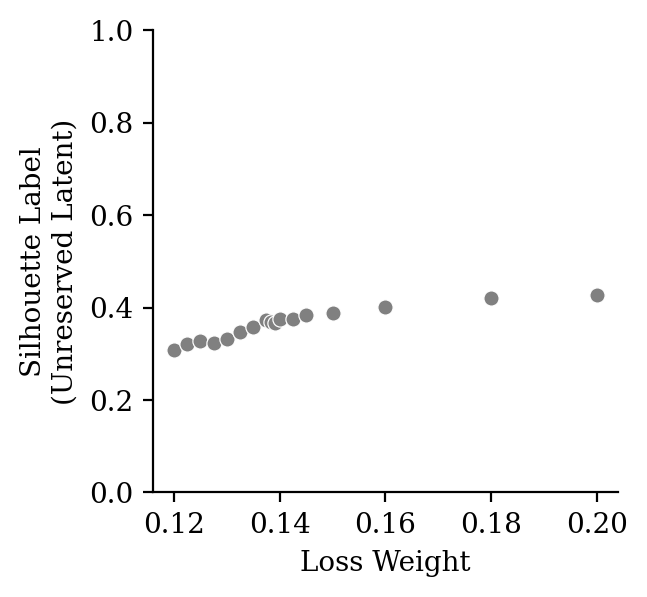

SignificanceResult(statistic=0.985294117647059, pvalue=6.341615043472023e-13)

In [181]:
plt.figure(figsize=(3, 3))
sns.scatterplot(x=scan_weight_coefficients[1:], y=unreserved_silhouette[1:], s=30, color="gray")
plt.xlabel("Loss Weight")
plt.ylabel("Silhouette Label\n(Unreserved Latent)")
# plt.yticks([])
plt.ylim(0, 1)
sns.despine()
plt.show()
scipy.stats.spearmanr(scan_weight_coefficients[1:], unreserved_silhouette[1:])

In [182]:
training_set = "validation"
unreserved_silhouette = []
for scan_weight_coefficient in tqdm.tqdm(scan_weight_coefficients):
    latent_subset = result[scan_weight_coefficient][training_set].X[:, :24]
    latent_subset_labels = result[scan_weight_coefficient][training_set].obs["mouse"].to_numpy().flatten()
    unreserved_silhouette.append(scib_metrics.silhouette_label(X=latent_subset, labels=latent_subset_labels))

100%|████████████████████████████████| 18/18 [00:00<00:00, 27.60it/s]


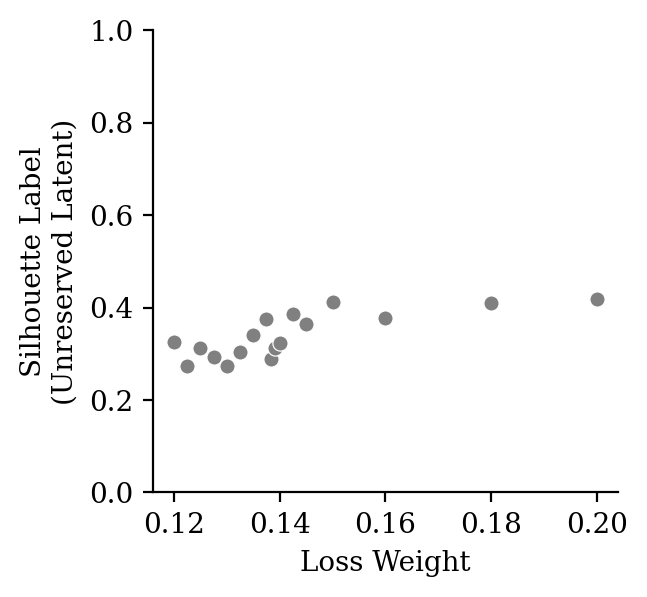

SignificanceResult(statistic=0.7549019607843138, pvalue=0.0004602984125426377)

In [183]:
plt.figure(figsize=(3, 3))
sns.scatterplot(x=scan_weight_coefficients[1:], y=unreserved_silhouette[1:], s=30, color="gray")
plt.xlabel("Loss Weight")
plt.ylabel("Silhouette Label\n(Unreserved Latent)")
# plt.yticks([])
plt.ylim(0, 1)
sns.despine()
plt.show()
scipy.stats.spearmanr(scan_weight_coefficients[1:], unreserved_silhouette[1:])

In [115]:
obs_key = "time_cat"
training_set = "validation"
mean_distances = []
for scan_weight_coefficient in scan_weight_coefficients:
    latent_subset = result[scan_weight_coefficient][training_set].X[:, get_factors_indices(obs_key)]
    latent_subset_labels = result[scan_weight_coefficient][training_set].obs[obs_key].to_numpy().flatten()
    latenst_subset_centroids = calculate_centroids_iqr(latent_subset, latent_subset_labels, multiplier=0.5)
    arr_stack = np.vstack(list(latenst_subset_centroids.values()))
    dist_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(arr_stack, 'euclidean'))
    mean_distance = np.mean(dist_matrix[np.triu_indices_from(dist_matrix, k=1)])
    mean_distances.append(mean_distance)

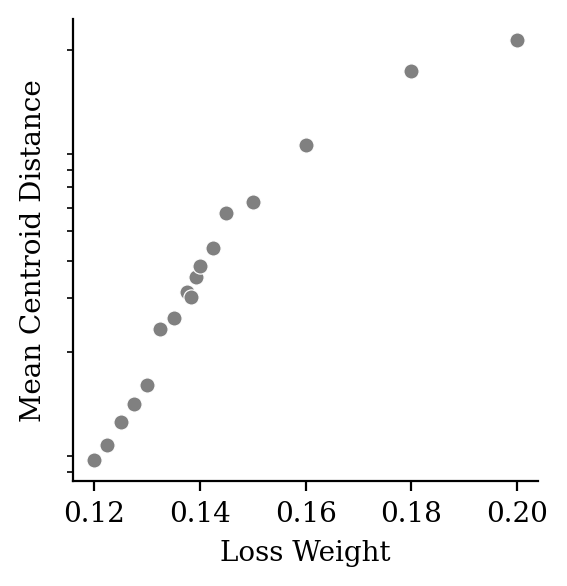

In [116]:
plt.figure(figsize=(3, 3))
sns.scatterplot(x=scan_weight_coefficients[1:], y=mean_distances[1:], s=30, color="gray")
plt.xlabel("Loss Weight")
plt.ylabel("Mean Centroid Distance")
plt.yticks([])
sns.despine()

In [117]:
obs_key = "zone"
training_set = "validation"
mean_distances = []
for scan_weight_coefficient in scan_weight_coefficients:
    latent_subset = result[scan_weight_coefficient][training_set].X[:, get_factors_indices(obs_key)]
    latent_subset_labels = result[scan_weight_coefficient][training_set].obs[obs_key].to_numpy().flatten()
    latenst_subset_centroids = calculate_centroids_iqr(latent_subset, latent_subset_labels, multiplier=0.5)
    arr_stack = np.vstack(list(latenst_subset_centroids.values()))
    dist_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(arr_stack, 'euclidean'))
    mean_distance = np.mean(dist_matrix[np.triu_indices_from(dist_matrix, k=1)])
    mean_distances.append(mean_distance)

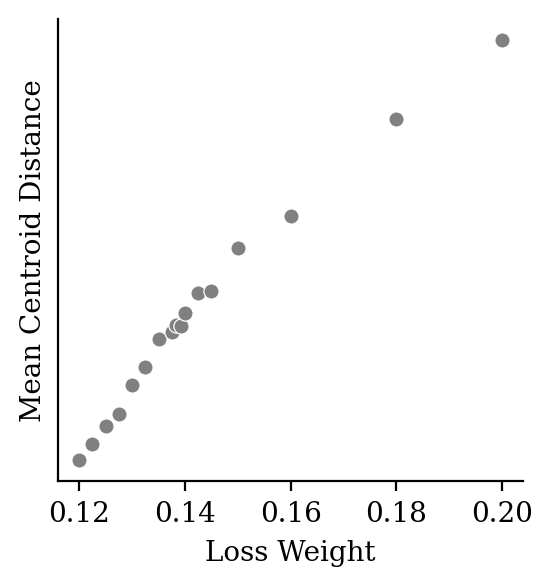

In [118]:
plt.figure(figsize=(3, 3))
sns.scatterplot(x=scan_weight_coefficients[1:], y=mean_distances[1:], s=30, color="gray")
plt.xlabel("Loss Weight")
plt.ylabel("Mean Centroid Distance")
plt.yticks([])
sns.despine()

In [119]:
obs_key = "status_control"
training_set = "validation"
mean_distances = []
for scan_weight_coefficient in scan_weight_coefficients:
    latent_subset = result[scan_weight_coefficient][training_set].X[:, get_factors_indices(obs_key)]
    latent_subset_labels = result[scan_weight_coefficient][training_set].obs[obs_key].to_numpy().flatten()
    latenst_subset_centroids = calculate_centroids_iqr(latent_subset, latent_subset_labels, multiplier=0.5)
    arr_stack = np.vstack(list(latenst_subset_centroids.values()))
    dist_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(arr_stack, 'euclidean'))
    mean_distance = np.mean(dist_matrix[np.triu_indices_from(dist_matrix, k=1)])
    mean_distances.append(mean_distance)

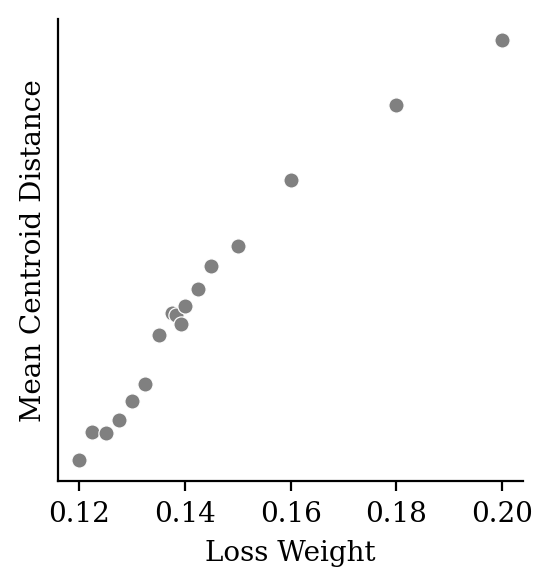

In [120]:
plt.figure(figsize=(3, 3))
sns.scatterplot(x=scan_weight_coefficients[1:], y=mean_distances[1:], s=30, color="gray")
plt.xlabel("Loss Weight")
plt.ylabel("Mean Centroid Distance")
plt.yticks([])
sns.despine()

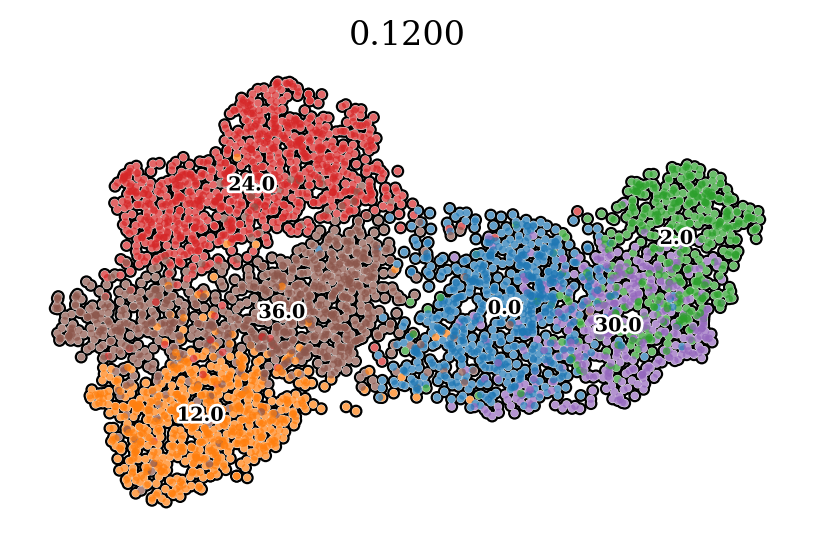

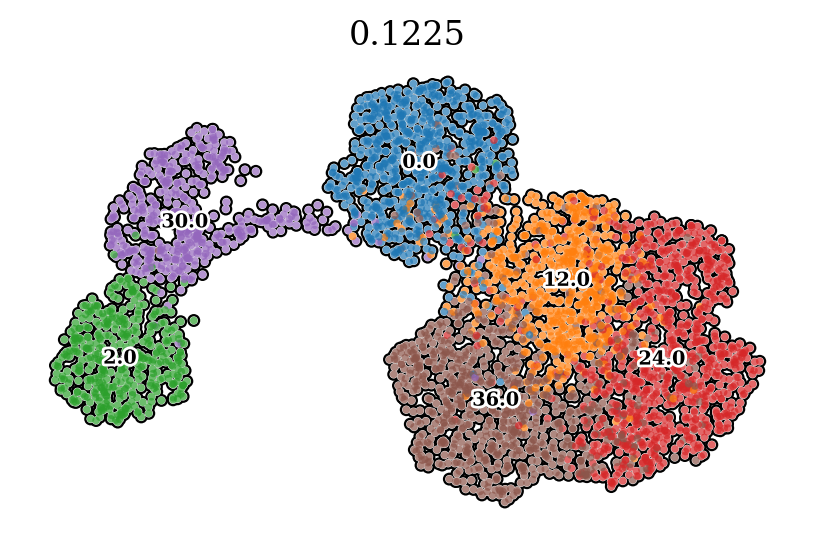

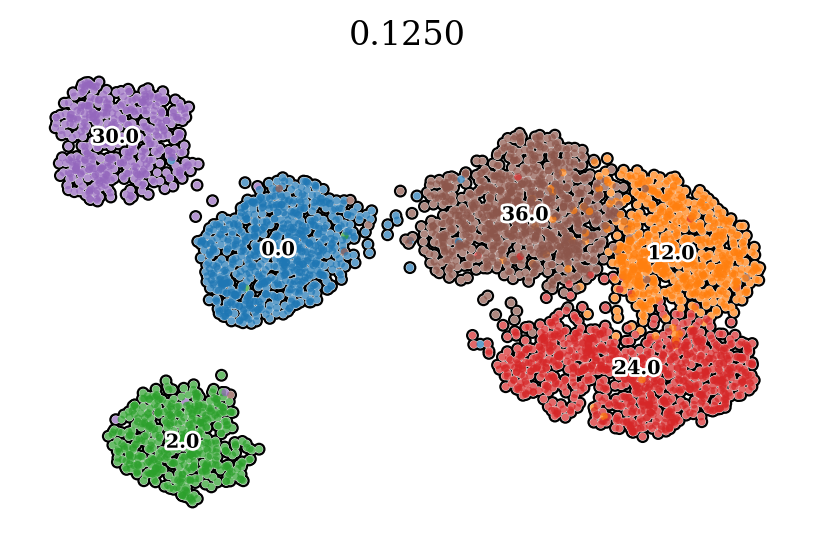

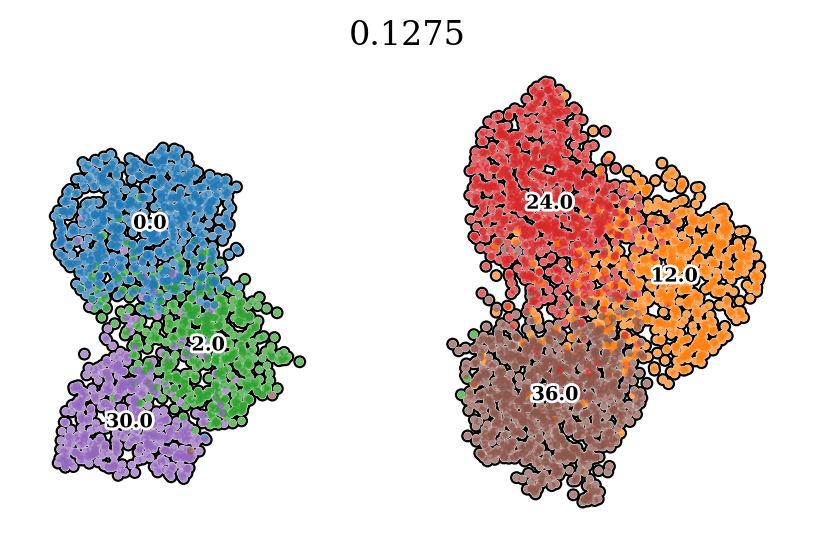

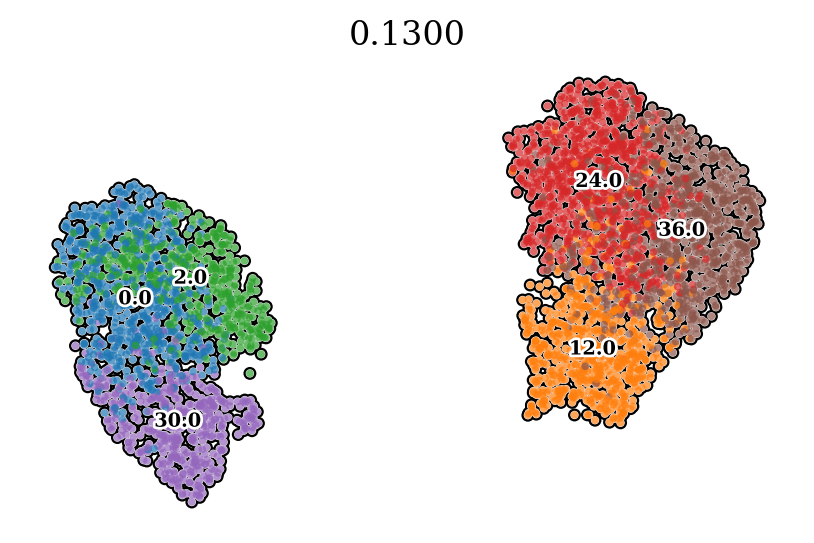

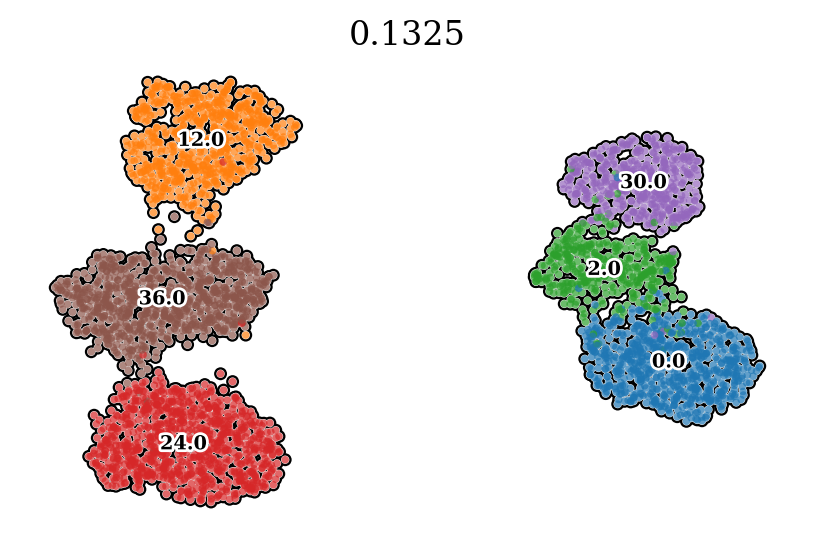

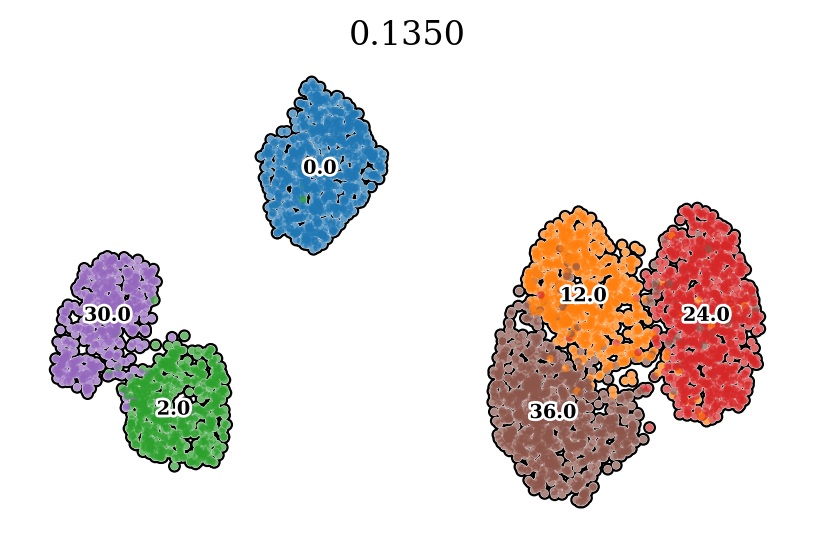

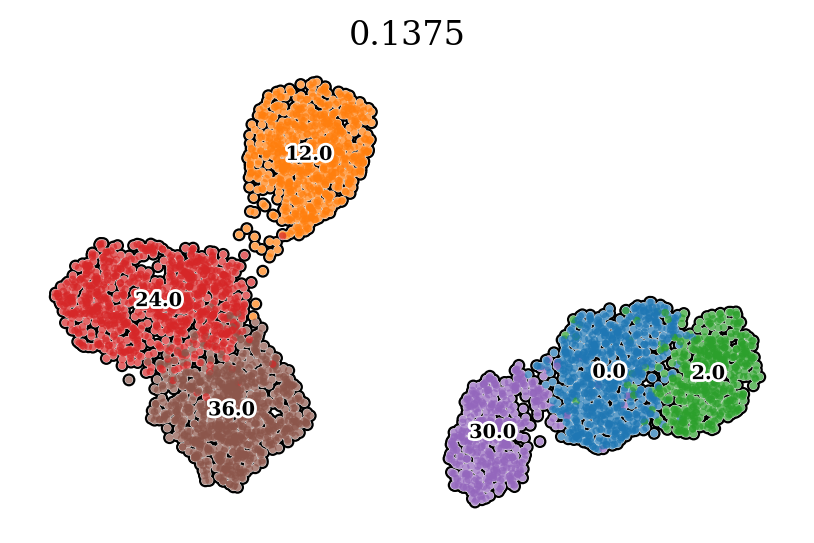

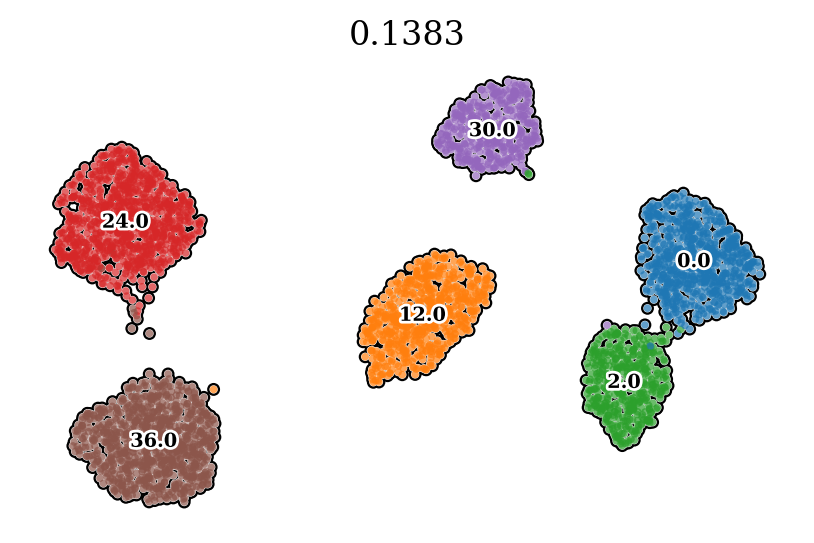

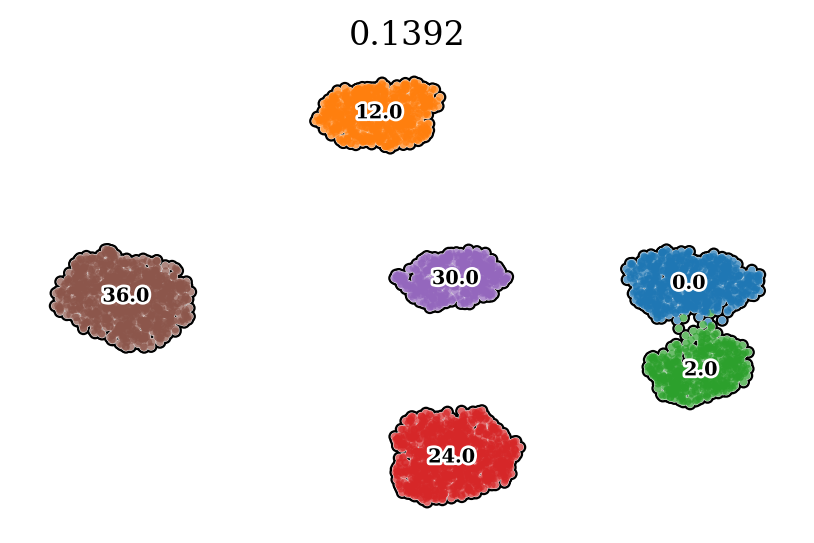

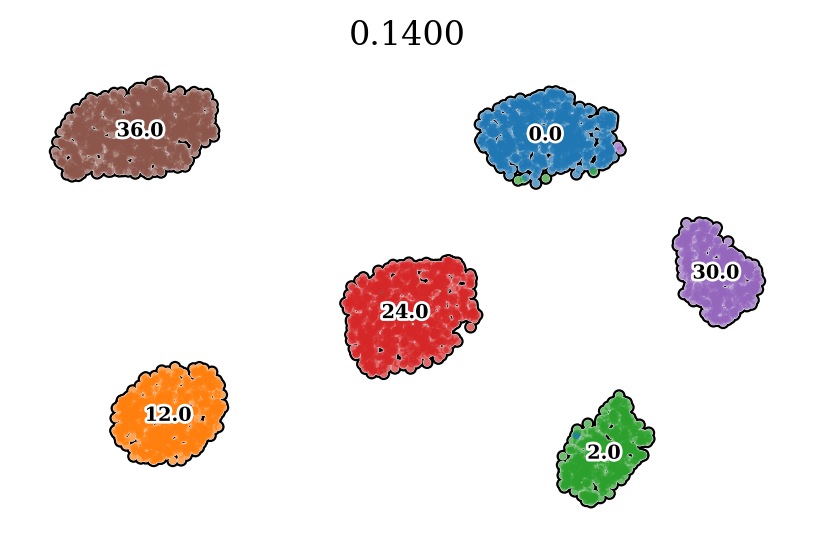

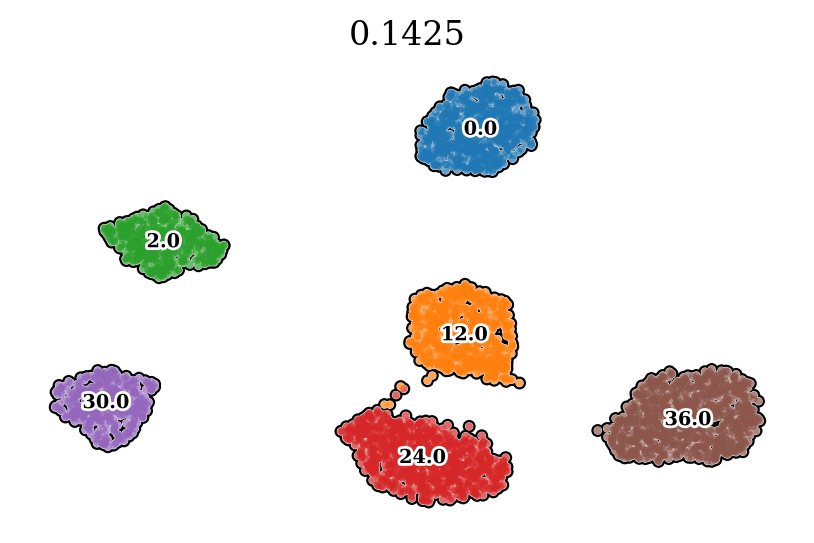

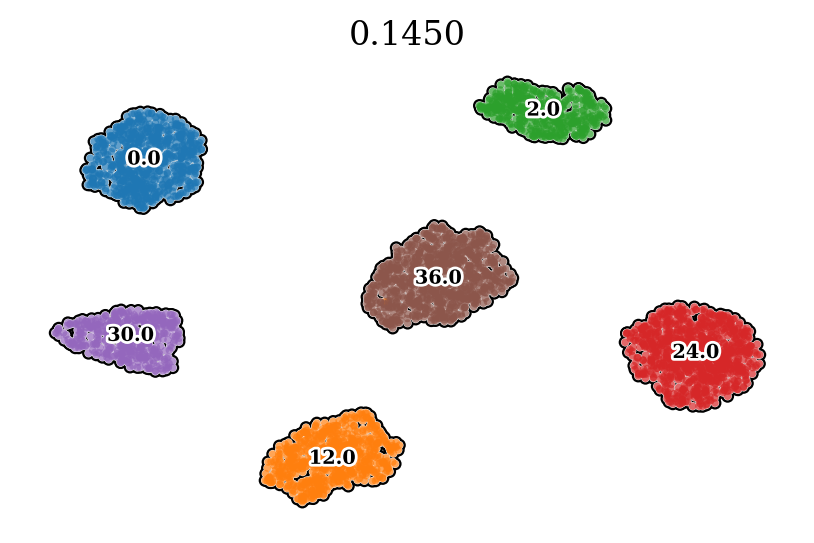

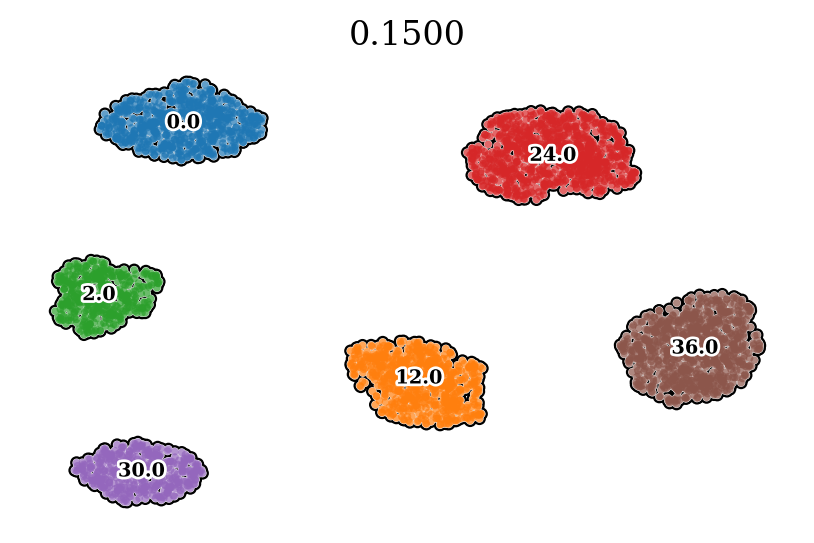

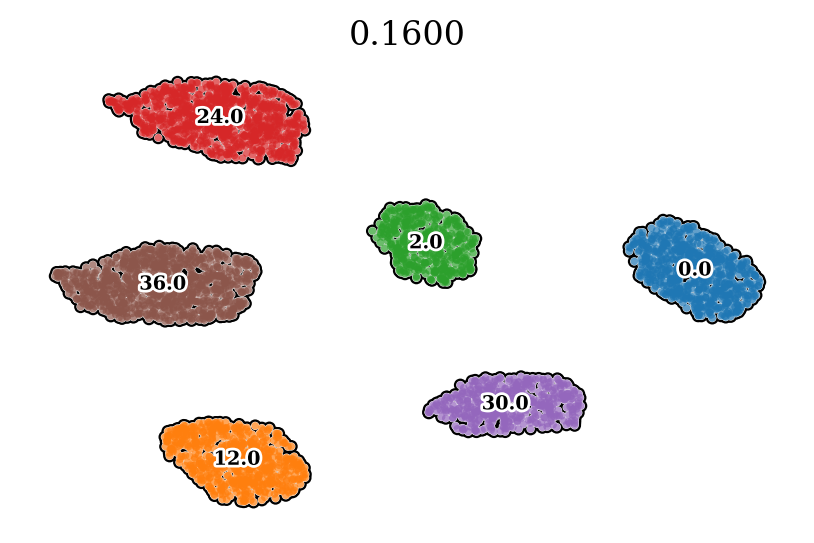

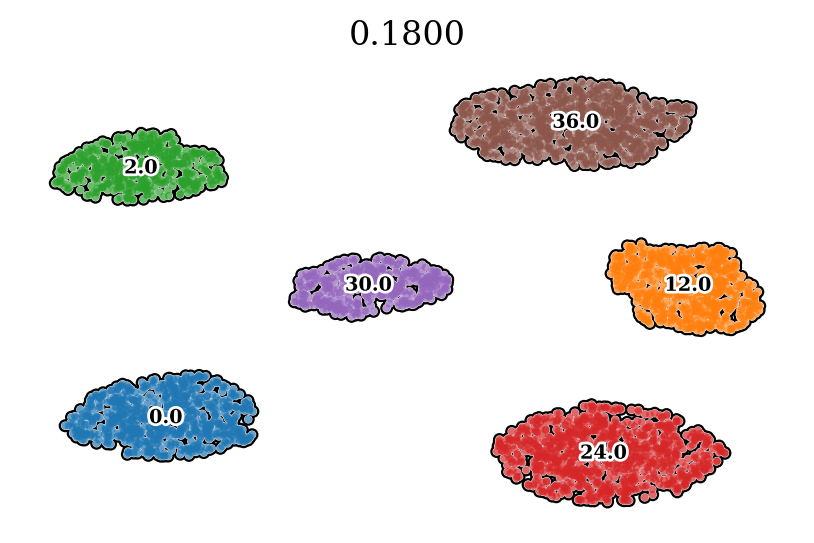

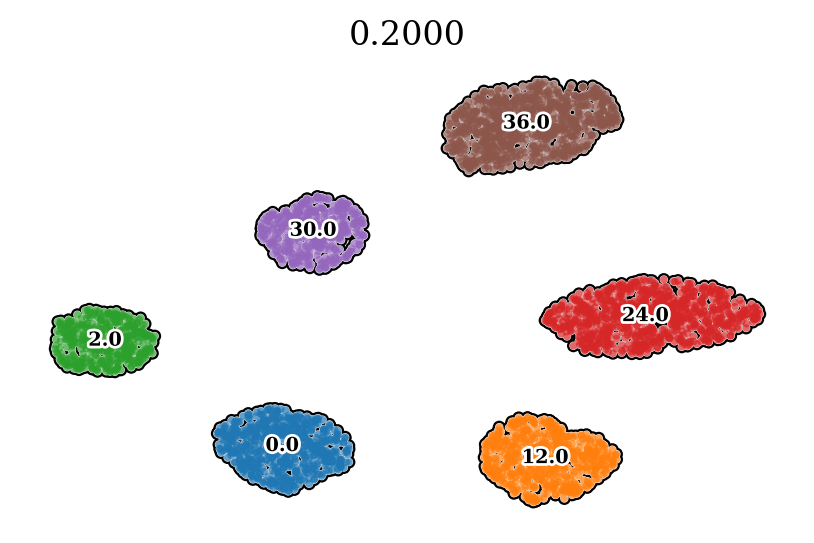

In [169]:
obs_key = "time_cat"
training_set = "validation"

for scan_weight_coefficient in scan_weight_coefficients[1:]:
    with suppress_stdout(), warnings.catch_warnings():
        warnings.simplefilter("ignore")
        latent_subset = result[scan_weight_coefficient][training_set][:, get_factors_indices(obs_key)].copy()
        sc.pp.neighbors(latent_subset)
        sc.tl.umap(latent_subset)
        title = "{:.4f}".format(scan_weight_coefficient)
        plt.figure(figsize=(5,3))
        sc.pl.umap(
            latent_subset,
            color=obs_key,
            s=30,
            ncols=2,
            frameon=False,
            legend_fontsize="x-small",
            show=False,
            ax=plt.gca(),
            legend_loc="on data",
            legend_fontweight="semibold",
            legend_fontoutline=2,
            title=title,
            add_outline=True,
        )
        plt.show()